In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [4]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [5]:
immune_classes = pd.read_csv(os.getcwd()+'/data/immune_classes.txt', sep = '\t')
immune_classes.rename(columns = {'Unnamed: 0':'t_ind'}, inplace = True)

In [6]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [7]:

covid_data = pd.read_csv(os.getcwd()+'/data/covid_data.csv')


In [8]:
start_date = '2020-07-01'
end_date_before_omicron = '2021-23-12'
end_date_before_xbb = '2022-23-12'

In [9]:
covid_data_between_start_and_omicron = covid_data[(covid_data['date']>=start_date) & (covid_data['date']<=end_date_before_omicron)]
covid_data_between_start_and_xbb = covid_data[(covid_data['date']>=start_date) & (covid_data['date']<=end_date_before_xbb)]

In [10]:
average_weekly_cases_between_start_and_omicron = covid_data_between_start_and_omicron.groupby('location')['new_cases_smoothed'].mean().reset_index()
average_weekly_cases_between_start_and_xbb = covid_data_between_start_and_xbb.groupby('location')['new_cases_smoothed'].mean().reset_index()

# #add a column with the population of each country
average_weekly_cases_between_start_and_omicron = average_weekly_cases_between_start_and_omicron.merge(covid_data_between_start_and_omicron[['location','population']].drop_duplicates(), on = 'location')
average_weekly_cases_between_start_and_xbb = average_weekly_cases_between_start_and_xbb.merge(covid_data_between_start_and_xbb[['location','population']].drop_duplicates(), on = 'location')

average_weekly_cases_between_start_and_omicron['weekly_cases'] = 7*average_weekly_cases_between_start_and_omicron['new_cases_smoothed']
average_weekly_cases_between_start_and_xbb['weekly_cases'] = 7*average_weekly_cases_between_start_and_xbb['new_cases_smoothed']

In [11]:
average_weekly_cases_between_start_and_omicron['weekly_case_density'] = average_weekly_cases_between_start_and_omicron['weekly_cases']/average_weekly_cases_between_start_and_omicron['population']
average_weekly_cases_between_start_and_xbb['weekly_case_density'] = average_weekly_cases_between_start_and_xbb['weekly_cases']/average_weekly_cases_between_start_and_xbb['population']

In [17]:
average_weekly_cases_between_start_and_omicron

,location,new_cases_smoothed,population,weekly_cases,weekly_case_density
0,Afghanistan,234.223483,4.112877e+07,1.639564e+03,0.000040
1,Africa,16861.554257,1.426737e+09,1.180309e+05,0.000083
2,Albania,373.247730,2.842318e+06,2.612734e+03,0.000919
3,Algeria,371.365590,4.490323e+07,2.599559e+03,0.000058
4,American Samoa,0.020044,4.429500e+04,1.403060e-01,0.000003
...,...,...,...,...,...
249,Wallis and Futuna,0.825146,1.159600e+04,5.776020e+00,0.000498
250,World,492859.244872,7.975105e+09,3.450015e+06,0.000433
251,Yemen,16.592725,3.369661e+07,1.161491e+02,0.000003
252,Zambia,414.928732,2.001767e+07,2.904501e+03,0.000145


In [18]:
# sns.lineplot(data = average_weekly_cases_between_start_and_omicron, x = 'location', y = 'weekly_case_density',hue = 'location')


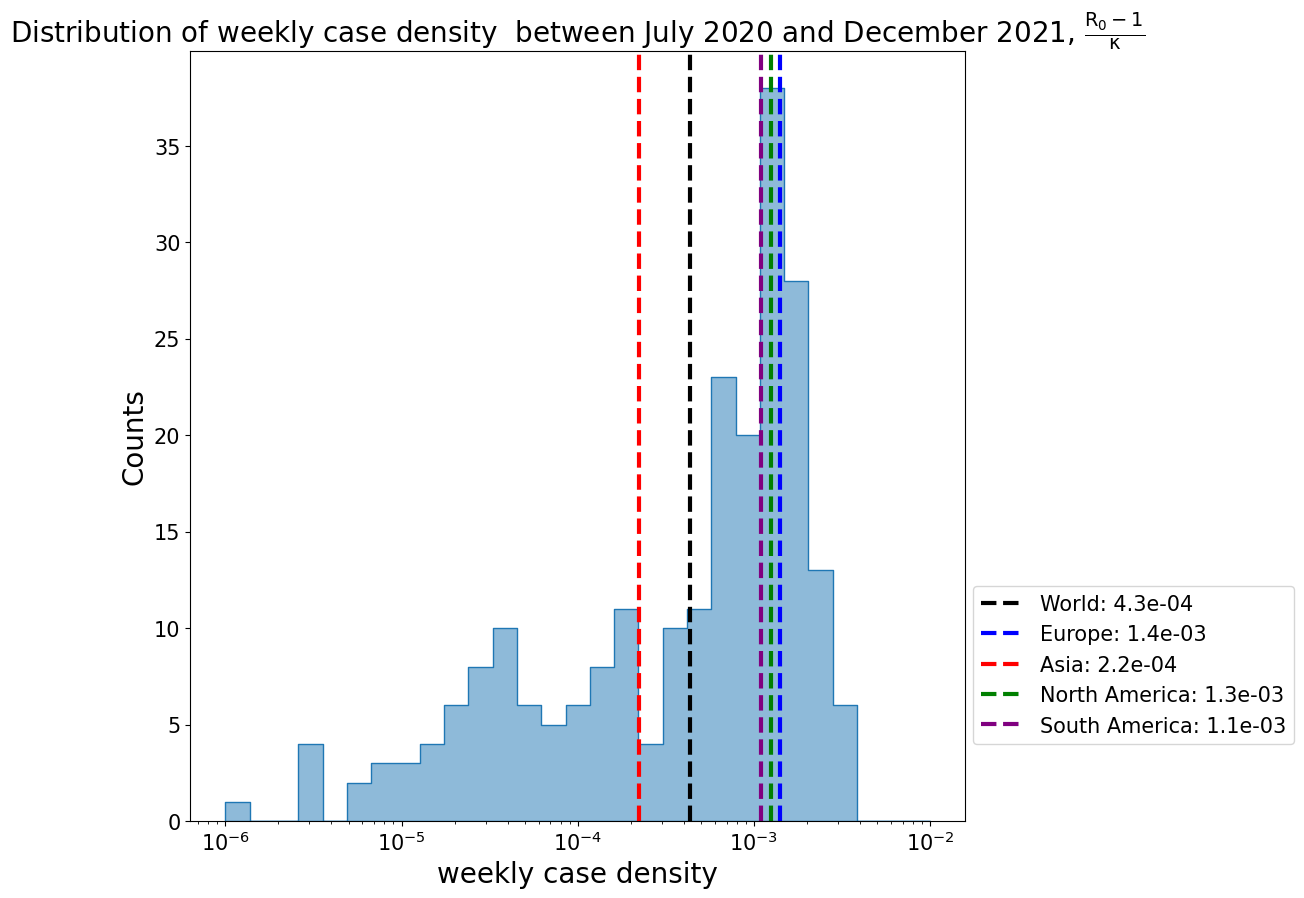

In [12]:
fig,ax= plt.subplots(1,1, figsize = (10,10),sharex= True)
ax = [ax]
sns.histplot(data = average_weekly_cases_between_start_and_omicron['weekly_case_density']
             , bins = np.logspace(-6,-2,30), kde = False, ax = ax[0], element='step',alpha=.5)
ax[0].set_title(r'Distribution of weekly case density  between July 2020 and December 2021, $\frac{R_0-1}{\kappa}$',fontsize=20)

# sns.histplot(data = average_weekly_cases_between_start_and_xbb['weekly_case_density']
                # , bins = np.logspace(-6,-2,30), kde = False, ax = ax[1], element='step',alpha=.5)

# ax[1].set_title('Distribution of avg. weekly case density between July 2020 and December 2022',fontsize=20)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=15)
    a.set_xscale('log')
    # a.set_yscale('log')
    a.set_xlabel('weekly case density',fontsize=20)
    a.set_ylabel('Counts',fontsize=20)

color_location = {'World':'black','Europe':'blue', 'Asia':'red', 'North America':'green', 'South America':'purple'}

for c in ['World','Europe', 'Asia', 'North America', 'South America']:
    ax[0].axvline(average_weekly_cases_between_start_and_omicron[average_weekly_cases_between_start_and_omicron['location']==c]['weekly_case_density'].values[0], linestyle = '--',color = color_location[c], label = f'{c}: {average_weekly_cases_between_start_and_omicron[average_weekly_cases_between_start_and_omicron["location"]==c]["weekly_case_density"].values[0]:.1e}')
    # ax[1].axvline(average_weekly_cases_between_start_and_xbb[average_weekly_cases_between_start_and_xbb['location']==c]['weekly_case_density'].values[0], linestyle = '--',color = color_location[c], label = f'{c}: {average_weekly_cases_between_start_and_xbb[average_weekly_cases_between_start_and_xbb["location"]==c]["weekly_case_density"].values[0]:.1e}')
    
ax[0].legend(loc=(1.01,.1),fontsize=15)
# ax[1].legend(loc=(1.01,.1),fontsize=15)

plt.savefig(output_folder+'kappa_estimation_case_density_distribution.pdf',bbox_inches='tight')

In [13]:
np.log10(average_weekly_cases_between_start_and_omicron.query('location == "Europe"')['population'])

70    8.872044
Name: population, dtype: float64

In [14]:
f'{(1/(1e-6*4e-4)):.1e}'

'2.5e+09'